In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from factor_analyzer import FactorAnalyzer
plt.style.use("ggplot")

In [2]:
df=pd.read_csv("C:/Users/gabbe/Downloads/marketing_campaign.csv",sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
df = df[(df.Marital_Status != 'Absurd') & (df.Marital_Status != 'Alone') & (df.Marital_Status != 'YOLO')]

In [4]:
education_map = {'Graduation':'Master Degree','2n Cycle':'Master Degree','Master':'Master Degree', 'Basic':'Under Graduate','PhD':'PhD'}

df['Education'] = df.Education.map(education_map)

In [5]:
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer)

days = df.Dt_Customer.max() - df.Dt_Customer

df['days_customer'] = (days/np.timedelta64(1, 'D')).astype(int)

In [6]:
df['Age'] = 2021-df.Year_Birth

In [7]:
df['Spent'] = df.MntFruits + df.MntWines + df.MntFishProducts + df.MntMeatProducts + df.MntSweetProducts + df.MntGoldProds
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']
df['children'] = df['Kidhome'] + df['Teenhome']
df['Is_Parent'] = np.where(df.children == 0, 0, 1)

<AxesSubplot:xlabel='Education', ylabel='Income'>

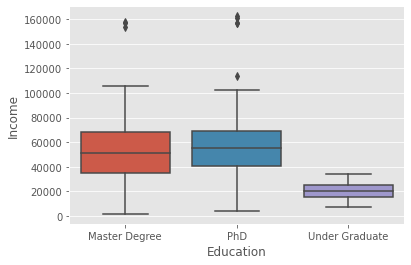

In [8]:
df = df[df != df.Income.max()]

sns.boxplot(x='Education',y='Income',data=df)

In [9]:
df['Income'].fillna(df.groupby('Education')['Income'].transform('median'),inplace=True)

In [10]:
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

In [11]:
df = df.drop(['ID','Year_Birth','Kidhome','Teenhome','Z_CostContact','Z_Revenue'],axis=1)

In [12]:
family_map = {'Single':1, 'Alone':1, 'Together':2, 'Married':2, 'Divorced':1, 'Widow':1}
df['Parents'] = df.Marital_Status.map(family_map)
df['Family_size'] = df.Parents + df.children

In [13]:
df.to_csv("C:/Users/gabbe/Downloads/customers.csv")

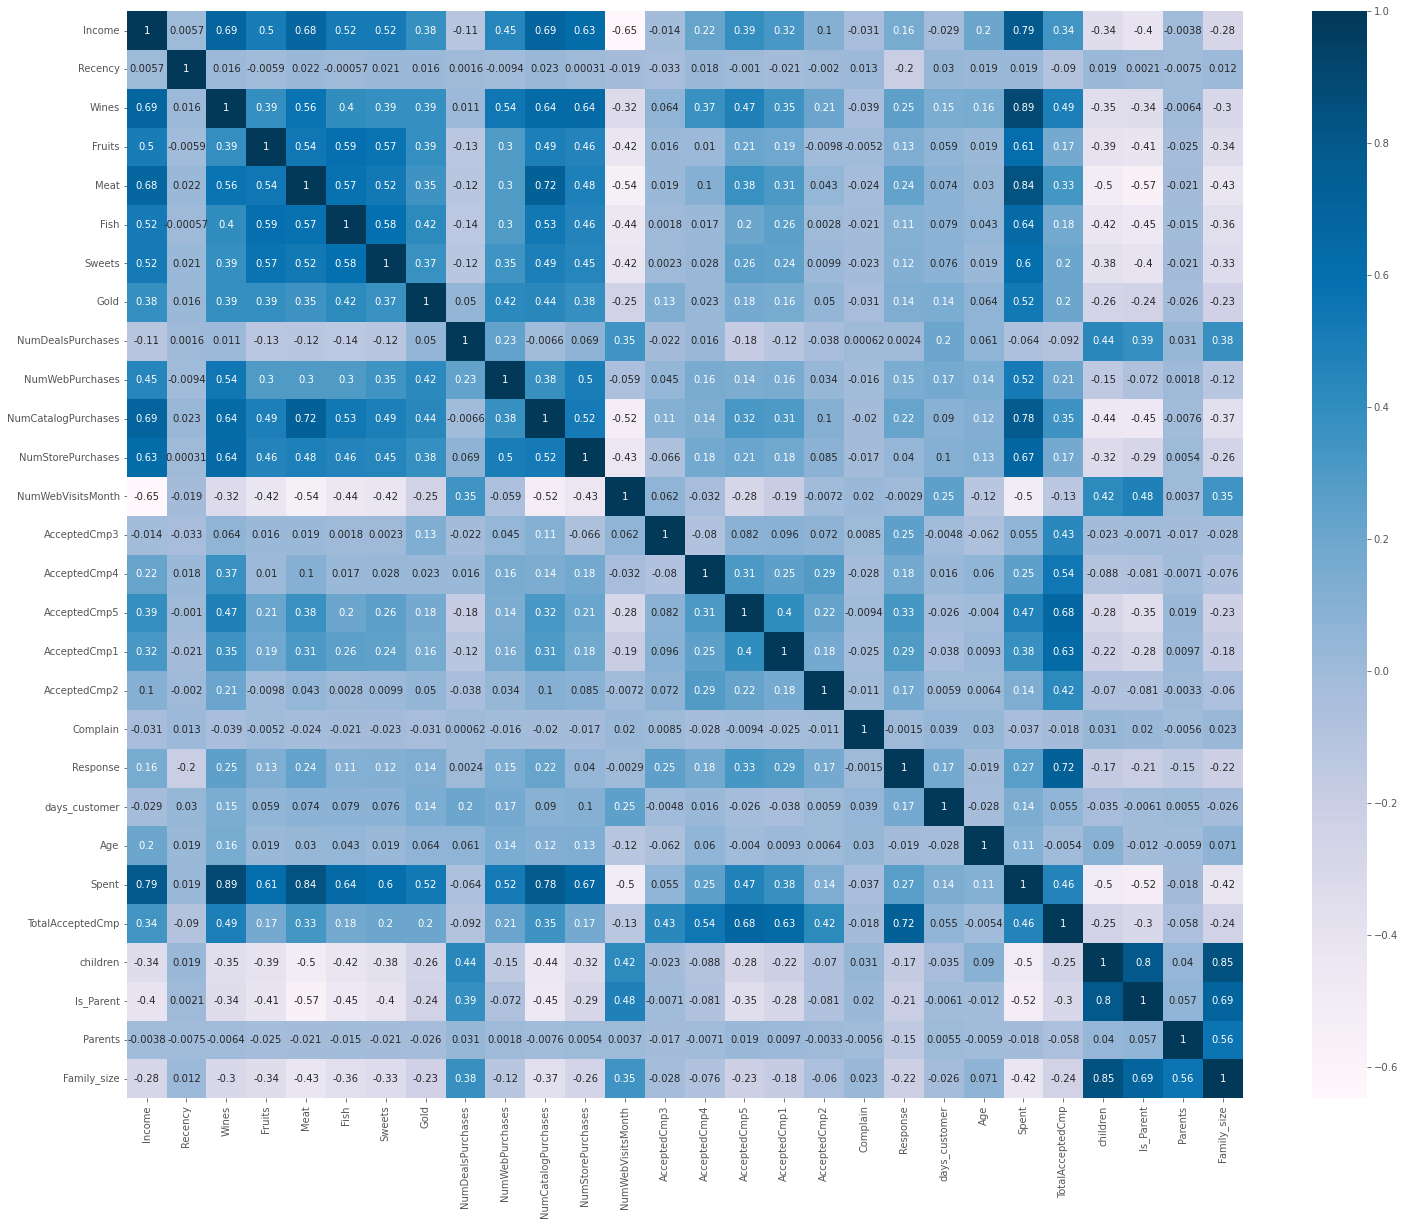

In [14]:
plt.figure(figsize=(25,20))
sns.heatmap(df.corr(),annot=True, cmap='PuBu')
plt.show()

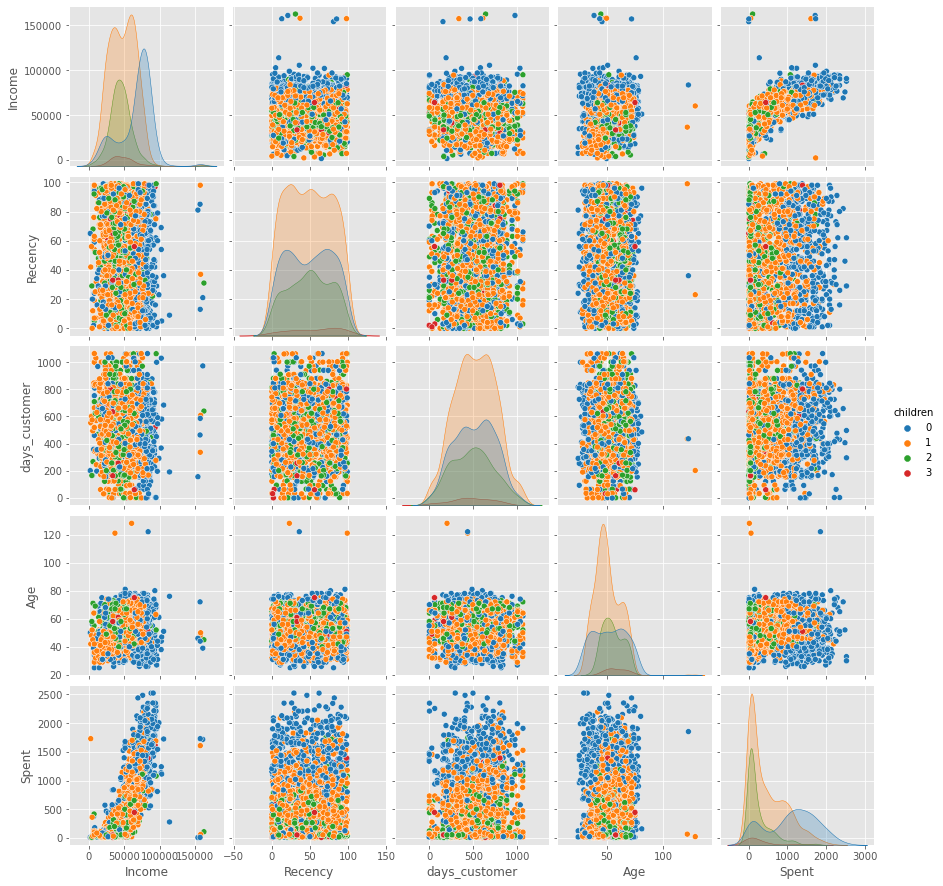

In [15]:
To_Plot = [ "Income", "Recency", "days_customer", "Age", "Spent", "children"]
sns.pairplot(df[To_Plot], hue= "children",palette= (["#1f77b4","#ff7f0e",'#2ca02c','#d62728']))

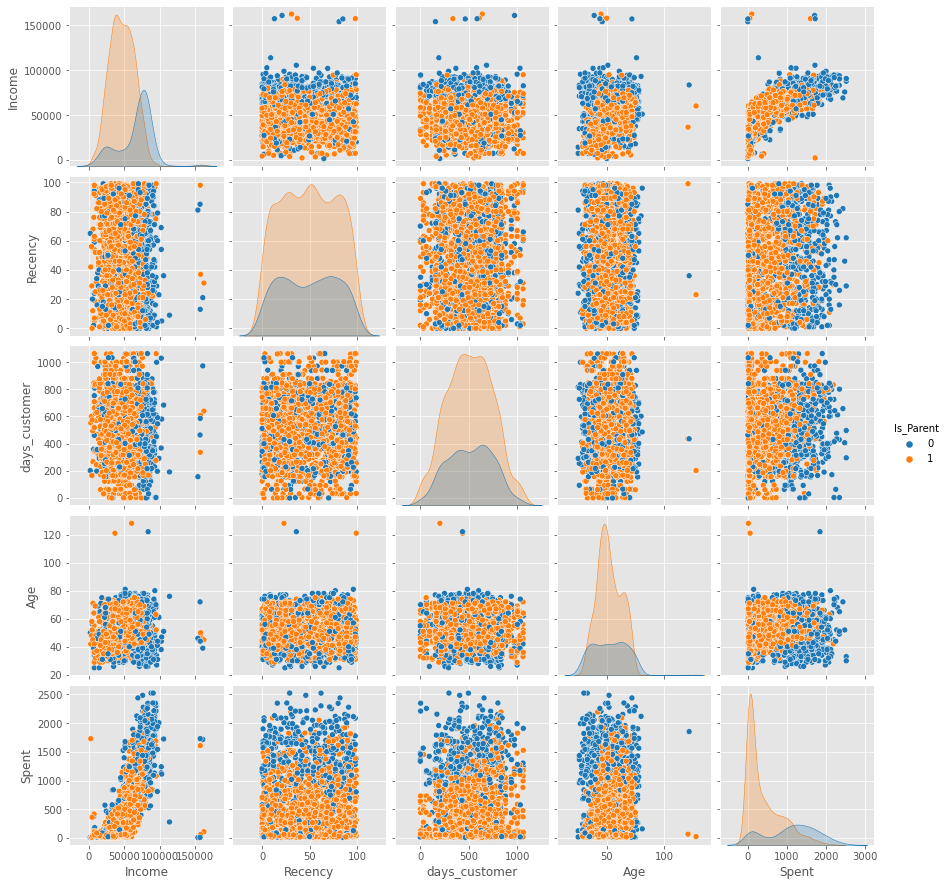

In [16]:
To_Plot = [ "Income", "Recency", "days_customer", "Age", "Spent",'Is_Parent']
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#1f77b4","#ff7f0e"]))

In [17]:
df = df.drop(['Education','Marital_Status','Dt_Customer','Is_Parent','Parents',"Family_size"],axis=1)

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_scaled = StandardScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [19]:
inertia = []
for i in range(1,10):
  km = KMeans(n_clusters=i).fit(df_scaled)
  inertia.append(km.inertia_/i)

C:\Users\gabbe\anaconda3\envs\fa\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Text(0, 0.5, 'Average Within-cluster Squared Distances')

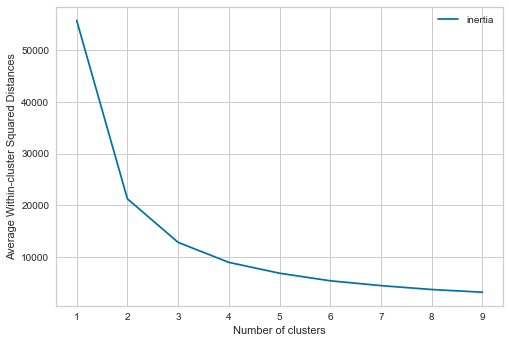

In [31]:
inertias = pd.DataFrame({"n_clusters":range(1,10), "inertia":inertia})
ax=inertias.plot(x="n_clusters", y="inertia")
plt.xlabel("Number of clusters")
plt.ylabel("Average Within-cluster Squared Distances")

Text(0.5, 0.98, 'Silhouette plots for K-Means clusters ')

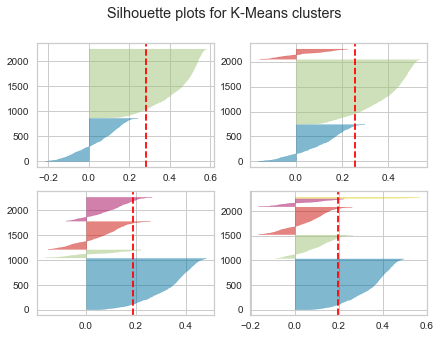

In [54]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2,2, figsize=(7,5))

for i in [2,3,4,5]:
  km = KMeans(n_clusters=i,n_init=20)
  q, mod = divmod(i,2)
  viz = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q-1][mod])
  viz.fit(df_scaled)

plt.suptitle("Silhouette plots for K-Means clusters ")

In [55]:
km = KMeans(n_clusters=4).fit(df_scaled)

<AxesSubplot:xlabel='Income', ylabel='Spent'>

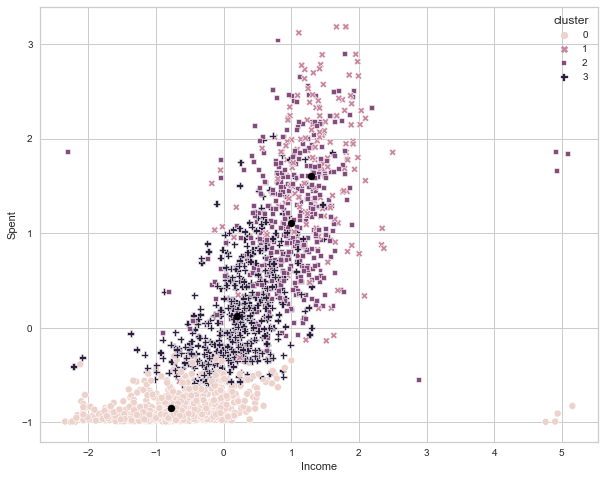

In [56]:
centers = pd.DataFrame(km.cluster_centers_, columns=df.columns)
df_scaled["cluster"] = km.labels_

fix, ax = plt.subplots(figsize=(10,8))

ax = sns.scatterplot(x="Income", y="Spent", data=df_scaled, hue="cluster", style="cluster", ax=ax)

centers.plot.scatter(x="Income",y="Spent",ax=ax, s=50, color="black", style="index")

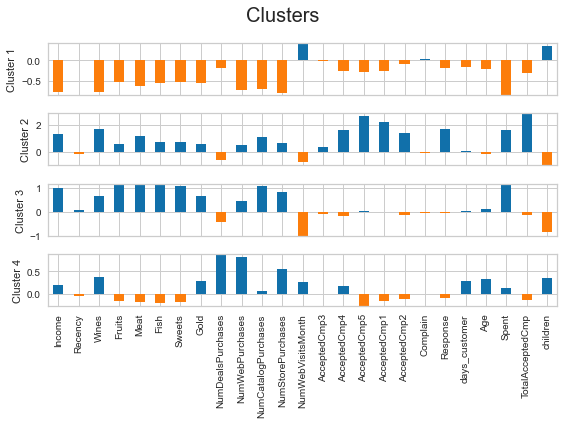

In [57]:
fig,axes = plt.subplots(4,1,sharex=True, figsize=(8,6))

for i,ax in enumerate(axes):
  center = centers.iloc[i,:]
  colors = ["#1170aa" if x>0 else "#fc7d0b" for x in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f"Cluster {i+1}")
  ax.set_ylim(min(1.01*center), max(1.01*center))

plt.suptitle("Clusters", fontsize=20)
plt.tight_layout()
plt.show()

### Factor extraction

In [58]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model = calculate_kmo(df_scaled)
kmo_model

C:\Users\gabbe\anaconda3\envs\fa\lib\site-packages\factor_analyzer\utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.8634230244568888

In [59]:
np.linalg.det(df_scaled.corr())

-2.7767416223339857e-36

In [64]:
df_scaled.drop("cluster",axis=1,inplace=True)

fa = FactorAnalyzer()

fa=fa.fit(df_scaled)
ev, v = fa.get_eigenvalues()

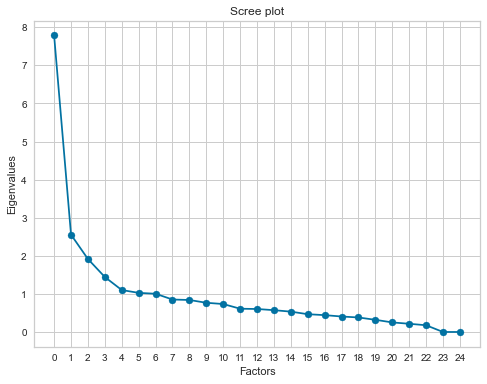

In [65]:
plt.figure(figsize=(8,6))

plt.scatter(range(0,df_scaled.shape[1]),ev)
plt.plot(range(0,df_scaled.shape[1]),ev)
plt.title("Scree plot")
plt.ylabel("Eigenvalues")
plt.xlabel("Factors")
plt.xticks(range(0,df_scaled.shape[1],1))
plt.show()

In [66]:
fa = FactorAnalyzer(n_factors=4, rotation="promax")

fa.fit(df_scaled)

factors_df = pd.DataFrame(fa.loadings_, index=df_scaled.columns)
factors_df = factors_df.transpose()
factors_df

,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,days_customer,Age,Spent,TotalAcceptedCmp,children
0,0.669664,0.007664,0.475650,0.816908,0.807093,0.849767,0.779284,0.588055,-0.168216,0.430918,...,0.145895,0.157845,-0.146587,-0.017624,0.086202,0.142893,0.015626,0.851365,-0.020588,-0.599114
1,0.242355,-0.026549,0.469427,-0.229568,0.021025,-0.232936,-0.171562,-0.101167,-0.020288,0.070870,...,0.571752,0.450302,0.461140,-0.024806,0.383344,-0.101327,0.108435,0.194557,0.907413,0.025516
2,-0.055892,-0.011560,0.231315,-0.019041,-0.085842,-0.030094,-0.012540,0.231362,0.632997,0.488491,...,-0.172105,-0.101061,-0.015122,0.013681,0.121125,0.399859,0.079839,0.128860,-0.009874,0.293767
3,-0.262403,-0.139376,-0.149342,0.079558,0.034750,0.077397,0.063411,0.089578,-0.093189,-0.078632,...,0.155081,0.204729,0.072381,0.012421,0.542501,0.182055,-0.236114,-0.038697,0.550854,-0.157471


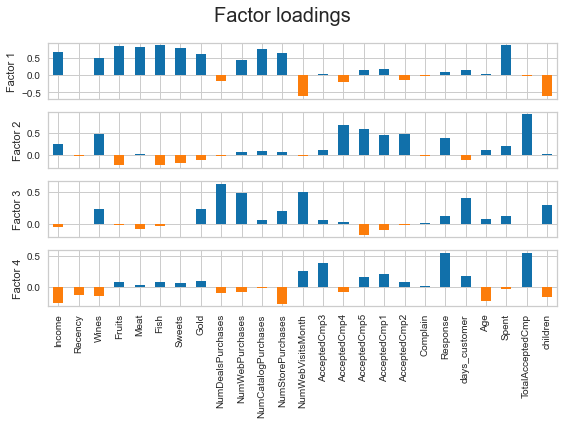

In [67]:
fig,axes = plt.subplots(4,1,sharex=True, figsize=(8,6))

for i,ax in enumerate(axes):
  center = factors_df.iloc[i,:]
  colors = ["#1170aa" if x>0 else "#fc7d0b" for x in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f"Factor {i+1}")

plt.suptitle("Factor loadings", fontsize=20)
plt.tight_layout()
plt.show()

In [68]:
fa_scores= fa.transform(df_scaled)

scores_df = pd.DataFrame(fa_scores, columns=["Factor_1","Factor_2","Factor_3","Factor_4"])

In [315]:
fa_scores = StandardScaler().fit_transform(fa_scores)

scores_df = pd.DataFrame(fa_scores, columns=["Factor_1","Factor_2","Factor_3","Factor_4"])

C:\Users\gabbe\anaconda3\envs\fa\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Text(0, 0.5, 'Average Within-cluster Squared Distances')

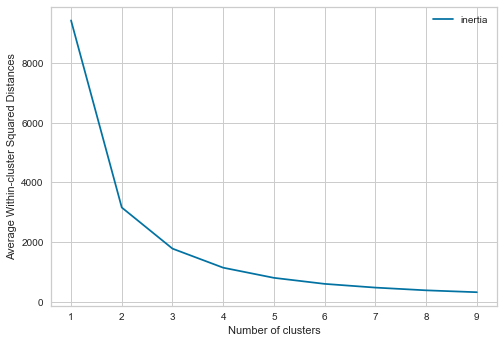

In [69]:
inertia = []
for i in range(1,10):
  km = KMeans(n_clusters=i).fit(scores_df)
  inertia.append(km.inertia_/i)


inertias = pd.DataFrame({"n_clusters":range(1,10), "inertia":inertia})
ax=inertias.plot(x="n_clusters", y="inertia")
plt.xlabel("Number of clusters")
plt.ylabel("Average Within-cluster Squared Distances")

In [121]:
km.fit_predict(scores_df)

array([0, 2, 1, ..., 0, 1, 2])

In [125]:
from sklearn.metrics import silhouette_score, silhouette_samples

score = silhouette_score(scores_df, km.labels_, metric="euclidean")

print(f"Silhoutte Score: {round(score,3)}")

Silhoutte Score: 0.242


Text(0.5, 0.98, 'Silhouette plots for K-Means clusters ')

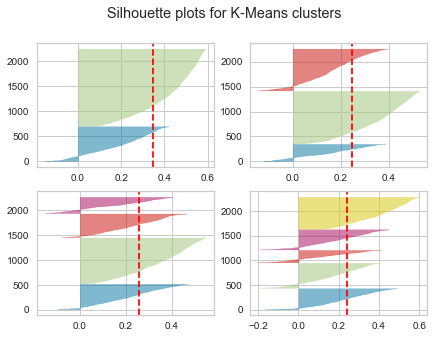

In [126]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2,2, figsize=(7,5))

for i in [2,3,4,5]:
  km = KMeans(n_clusters=i)
  q, mod = divmod(i,2)
  viz = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q-1][mod])
  viz.fit(scores_df)

plt.suptitle("Silhouette plots for K-Means clusters ")

In [127]:
km = KMeans(n_clusters=5).fit(scores_df)

centers = pd.DataFrame(km.cluster_centers_, columns=scores_df.columns)
scores_df["cluster"] = km.labels_

In [129]:
fa.get_factor_variance()

(array([6.40903818, 2.69292271, 1.37481317, 1.22803006]),
 array([0.25636153, 0.10771691, 0.05499253, 0.0491212 ]),
 array([0.25636153, 0.36407844, 0.41907096, 0.46819216]))

### 5 clusters seem to be optimal with silhouette scores above average with the most uniform sizes

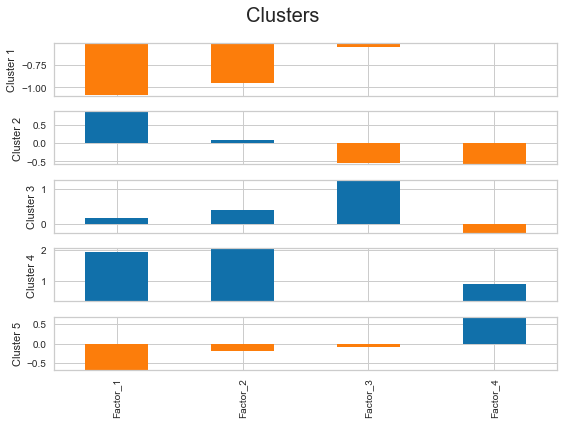

In [128]:
fig,axes = plt.subplots(5,1,sharex=True, figsize=(8,6))

for i,ax in enumerate(axes):
  center = centers.iloc[i,:]
  colors = ["#1170aa" if x>0 else "#fc7d0b" for x in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f"Cluster {i+1}")
  ax.set_ylim(min(1.01*center), max(1.01*center))

plt.suptitle("Clusters", fontsize=20)
plt.tight_layout()
plt.show()